**ResNet-18 Architecture**

**Importing the modules**

In [2]:
import torch
import torch.nn as nn

**Defining the ResNet-18**

In [3]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)




**Training the model and printing the size of the model**

In [4]:
def Main():
    BATCH_SIZE = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNet101(img_channel=3, num_classes=1000).to(device)
    y = net(torch.randn(BATCH_SIZE, 3, 224, 224)).to(device)
    assert y.size() == torch.Size([BATCH_SIZE, 1000])
    print(y.size())


if __name__ == "__main__":
    Main()

torch.Size([4, 1000])


**ResNet-18**

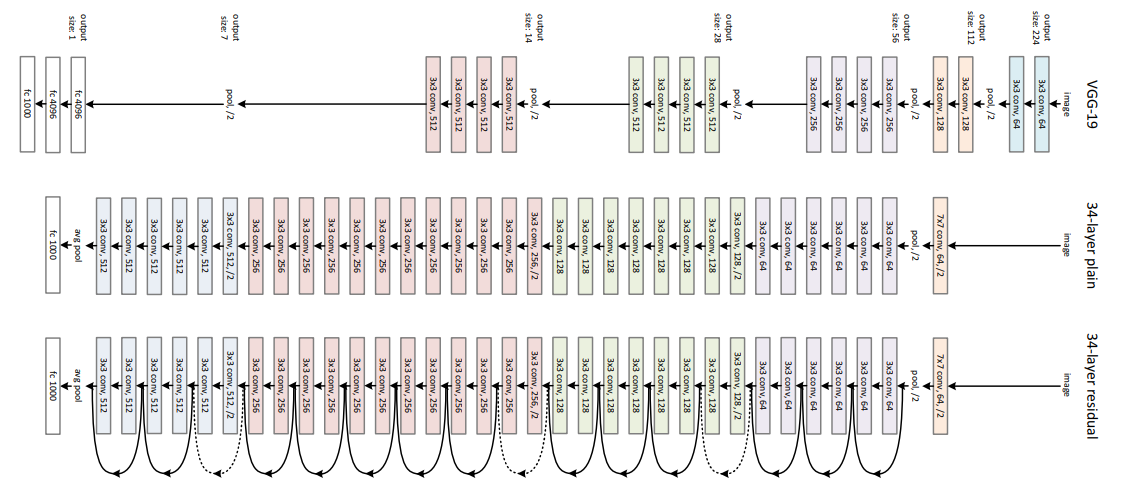